<a href="https://colab.research.google.com/github/zova137/NMA/blob/master/Load_steinmetz_decisions_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [193]:
#@title Import libraries
import os, requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler




In [194]:
sb.set(color_codes=True)

In [195]:
#@title Data retrieval


fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [196]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]  #0:38 recording every 4 recording belong to one mouse I guess
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [226]:

mice_data = []


for i, mouse in enumerate(alldat):
      response = mouse['response']   #higher contrast in right means -1 & higher contrast in left means 1, has values -1, 0, 1
      prev_response = np.zeros(mouse['response'].size)  
      prev_response[1:] = response[:response.size - 1]  #for previous response: higher contrast in right means -1 & higher contrast in left means 1, has values -1, 0, 1
      response_time = mouse['response_time']
      contrast_left = mouse['contrast_left']  # has these values: 0 , .25, .5, 1
      contrast_right = mouse['contrast_right']  # has these values: 0 , .25, .5, 1
      contrast_sum = contrast_left + contrast_right #useful to exclude no go trials contrast_sum=0
      deltaC=contrast_dir = contrast_left - contrast_right  #negative deltaC means right stimulus has higher contrast (same as response )
      contrast_diff = 1 - np.abs(contrast_left - contrast_right) #1 is most difficult(same contrast) & 0 is easiest. values are 0,.25, .5, .75, 1
      feedback_type = mouse['feedback_type']  #1 for reward or positive response and -1 for negative response
      mouse_name = mouse['mouse_name']
      #name = np.repeat(mouse['mouse_name'], response.size)
      trial_num = np.arange(response.size) + 1
      data = pd.DataFrame(np.column_stack(
          [trial_num, prev_response, response, response_time, contrast_left, contrast_right, contrast_sum, contrast_diff, contrast_dir,  feedback_type]), 
                      columns = ['trial number', 'prev response', 'response', 'response time',  'contrast_left', 'contrast sum', 'contrast_right', 'difficulty', 'deltaC','reward' ])
      mice_data.append(data) 
  

mice_data = pd.concat(mice_data)  #10050 trials
data=mice_data


In [227]:
data=data.reset_index()
del data['index']
data.reindex()

,trial number,prev response,response,response time,contrast_left,contrast sum,contrast_right,difficulty,deltaC,reward
0,1.0,0.0,1.0,1.150204,1.0,0.00,1.00,0.00,1.00,1.0
1,2.0,1.0,-1.0,1.399503,0.0,0.50,0.50,0.50,-0.50,1.0
2,3.0,-1.0,1.0,0.949291,1.0,0.50,1.50,0.50,0.50,1.0
3,4.0,1.0,0.0,2.266802,0.0,0.00,0.00,1.00,0.00,1.0
4,5.0,0.0,1.0,0.816776,0.5,1.00,1.50,0.50,-0.50,-1.0
...,...,...,...,...,...,...,...,...,...,...
10045,339.0,0.0,0.0,2.297503,1.0,0.25,1.25,0.25,0.75,-1.0
10046,340.0,0.0,-1.0,1.158803,1.0,0.25,1.25,0.25,0.75,-1.0
10047,341.0,-1.0,0.0,2.003709,1.0,0.25,1.25,0.25,0.75,-1.0
10048,342.0,0.0,0.0,2.076758,1.0,0.25,1.25,0.25,0.75,-1.0


In [206]:
go_data=data[data['contrast sum']!=0]  #exclude no go data
go_data


,trial number,prev response,response,response time,contrast_left,contrast sum,contrast_right,difficulty,deltaC,reward,strategy
1,2.0,1.0,-1.0,1.399503,0.0,0.50,0.50,0.50,-0.50,1.0,win shift
2,3.0,-1.0,1.0,0.949291,1.0,0.50,1.50,0.50,0.50,1.0,win shift
4,5.0,0.0,1.0,0.816776,0.5,1.00,1.50,0.50,-0.50,-1.0,lose shift
9,10.0,0.0,1.0,1.249668,1.0,0.50,1.50,0.50,0.50,1.0,win shift
12,13.0,0.0,1.0,1.116564,0.5,0.25,0.75,0.75,0.25,1.0,win shift
...,...,...,...,...,...,...,...,...,...,...,...
10045,339.0,0.0,0.0,2.297503,1.0,0.25,1.25,0.25,0.75,-1.0,lose stay
10046,340.0,0.0,-1.0,1.158803,1.0,0.25,1.25,0.25,0.75,-1.0,lose shift
10047,341.0,-1.0,0.0,2.003709,1.0,0.25,1.25,0.25,0.75,-1.0,lose shift
10048,342.0,0.0,0.0,2.076758,1.0,0.25,1.25,0.25,0.75,-1.0,lose stay


In [ ]:
#@title Describe dataframe
  
#mice_data.describe(include='all')
#data.response_time.describe()

,trial number,prev response,response,response time,contrast_left,contrast_right,difficulty,deltaC,reward
count,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000
mean,141.301990,-0.000100,-0.000100,1.422832,0.344478,0.332537,0.567861,0.011940,0.377711
std,93.717396,0.819153,0.819275,0.661416,0.396888,0.388877,0.377375,0.573613,0.925969
min,1.000000,-1.000000,-1.000000,0.479414,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,65.000000,-1.000000,-1.000000,0.842289,0.000000,0.000000,0.250000,-0.500000,-1.000000
50%,129.500000,0.000000,0.000000,1.183334,0.250000,0.250000,0.500000,0.000000,1.000000
75%,204.000000,1.000000,1.000000,2.102538,0.500000,0.500000,1.000000,0.500000,1.000000
max,447.000000,1.000000,1.000000,2.713576,1.000000,1.000000,1.000000,1.000000,1.000000


Section below is different catgorizing for one recording (alldat[11]). If you want to make it for all 39 ([0:38])recordings, just change ucomment the last line of dataframe section i.e. data=mice_data

In [229]:
#@title Categorizing based on history & feedback



'''categorized based history which is same(stay) or different(shift)'''
stay=data[data['prev response']==data['response']] #109 trials had same ans
shift=data[data['prev response']!=data['response']] #243 trials had shifted answer


'''categorized based history & reward'''
win_stay=stay[stay['reward']==1]  #64 trials
lose_stay=stay[stay['reward']==-1]  #45 trials
win_shift=shift[shift['reward']==1] #182 trials
lose_shift=shift[shift['reward']==-1] #52 trials

data['strategy']=np.zeros(len(data))

# print(len(data))

for j in range(len(data)):
 
  if (data['prev response'][j]==data['response'][j]):
    if (data['reward'][j]==1):
          data['strategy'][j]='win stay'
    elif (data['reward'][j]==-1):
          data['strategy'][j]='lose stay'          
  else :
    if (data['reward'][j]==1):
          data['strategy'][j]='win shift'
    elif (data['reward'][j]==-1):
          data['strategy'][j]='lose shift'



data
#categorized_data=pd.DataFrame[(trial_num, win_stay)], columns=[('no', 'win_stay')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to b

,trial number,prev response,response,response time,contrast_left,contrast sum,contrast_right,difficulty,deltaC,reward,strategy
0,1.0,0.0,1.0,1.150204,1.0,0.00,1.00,0.00,1.00,1.0,win shift
1,2.0,1.0,-1.0,1.399503,0.0,0.50,0.50,0.50,-0.50,1.0,win shift
2,3.0,-1.0,1.0,0.949291,1.0,0.50,1.50,0.50,0.50,1.0,win shift
3,4.0,1.0,0.0,2.266802,0.0,0.00,0.00,1.00,0.00,1.0,win shift
4,5.0,0.0,1.0,0.816776,0.5,1.00,1.50,0.50,-0.50,-1.0,lose shift
...,...,...,...,...,...,...,...,...,...,...,...
10045,339.0,0.0,0.0,2.297503,1.0,0.25,1.25,0.25,0.75,-1.0,lose stay
10046,340.0,0.0,-1.0,1.158803,1.0,0.25,1.25,0.25,0.75,-1.0,lose shift
10047,341.0,-1.0,0.0,2.003709,1.0,0.25,1.25,0.25,0.75,-1.0,lose shift
10048,342.0,0.0,0.0,2.076758,1.0,0.25,1.25,0.25,0.75,-1.0,lose stay


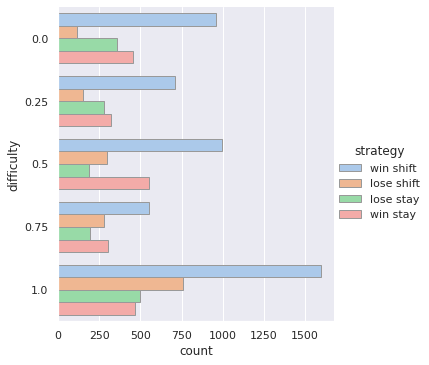

In [235]:
strategy_difficulty=sb.catplot(y="difficulty", hue="strategy", kind="count", palette="pastel", edgecolor=".6", data=data);

In [236]:
strategy_difficulty=sb.catplot(y="difficulty", hue="strategy", kind="count", palette="pastel", edgecolor=".6", data=data.query('contrast sum !=0').query);

SyntaxError: ignored

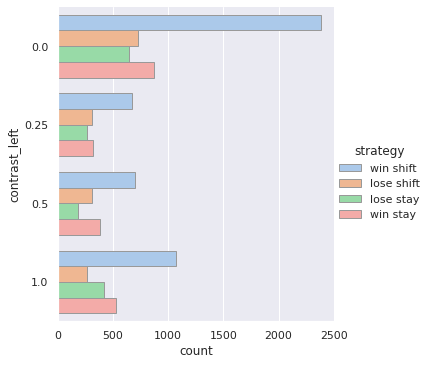

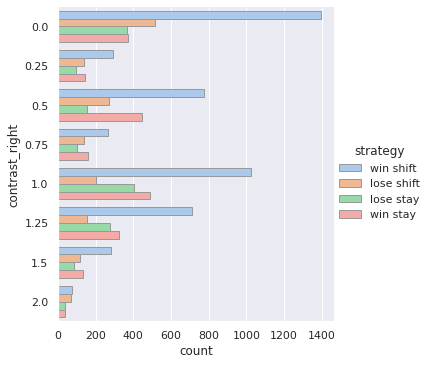

In [231]:

strategy_leftc=sb.catplot(y="contrast_left", hue="strategy", kind="count", palette="pastel", edgecolor=".6", data=data); 

strategy_rightc=sb.catplot(y="contrast_right", hue="strategy", kind="count", palette="pastel", edgecolor=".6",data=data);


In [121]:
data.to_excel("strategy2.xlsx")

In [203]:
#@title Categorizing go tasks(exclude no go) based on history & feedback

go=data[contrast_sum!=0]  #198 from 343 trials

'''categorized go tasks based history which is same(stay) or different(shift)'''
stay=go[go['prev response']==go['response']] #67 trials had same ans
shift=go[go['prev response']!=go['response']] #131 trials had shifted answer


'''categorized based history & reward'''
win_stay=stay[stay['reward']==1]  #46 trials
lose_stay=stay[stay['reward']==-1]  #21 trials
win_shift=shift[shift['reward']==1] #114 trials
lose_shift=shift[shift['reward']==-1] #17 trials

#lose_stay.shape

go_data['strategy']=np.zeros(len(go_data))

# print(len(data))

for j in range(len(go_data)):
 
  if (go_data['prev response'][j]==go_data['response'][j]):
    if (go_data['reward'][j]==1):
          go_data['strategy'][j]='win stay'
    elif (go_data['reward'][j]==-1):
          go_data['strategy'][j]='lose stay'          
  else :
    if (go_data['reward'][j]==1):
          go_data['strategy'][j]='win shift'
    elif (go_data['reward'][j]==-1):
          go_data['strategy'][j]='lose shift'

ValueError: ignored

In [ ]:
#@title Categorizing go tasks(exclude no go) based on history & feedback

'''categorize based on same ans: left, right, nogo''' 

same_ans=data[data['prev response']==data['response']]  #109 trials had same ans
same_ans_left=data[(data['prev response']==data['response']) & (data['response']==-1)] #54 trials had same ans for rotating left (higher contrast in right)
same_ans_right=data[(data['prev response']==data['response']) & (data['response']==1)] #22 trials had same ans for rotating right (higher contrast in left)
same_ans_nogo=data[(data['prev response']==data['response']) & (data['response']==0)] #33 trials had same ans for nogo
same_ans_exclude_nogo=data[(data['prev response']==data['response']) & (data['response']!=0)] #76 trials, excluded nogo from same answers whether left or right




#same_ans_left.shape  #check trial numbers of same response to left
#pd.set_option('display.max_rows', None) #display all rows of dataframe
#same_ans

In [ ]:
'''categorize same ans based on response time'''

same_ans_fast=same_ans[same_ans['response time']<=.9] #32 trials
same_ans_mid=same_ans[(same_ans['response time']<=1.5) & (same_ans['response time'] >.9)]  #36 trials
same_ans_slow=same_ans[same_ans['response time']>1.5] #41 trials
#same_ans_fast.describe(include='all')
#same_ans_mid.describe(include='all')
#same_ans_slow.describe(include='all')
#same_ans_fast.sort_values(by=['response time'])  #doesn't seems meaningful
#same_ans_fast.sort_values(by=['deltaC']) #doesn't seem meaningful either
same_ans_slow.sort_values(by=['deltaC']) #all nogo task done wrong in <1.9 response time (trial 176, 72 was wrong at response time 2.09 & 2.18) (18 nogo task done correct and all at response time >1.93)

In [ ]:
'''categorize same ans based on difficulty of tasks: 1, .75, .5, .25, 0'''

same_ans_diff100=same_ans_exclude_nogo[same_ans_exclude_nogo['difficulty']==1]  #24 trials with same ans in difficulty100 (same contrast, nogo task but act was wrong)
same_ans_diff75=same_ans_exclude_nogo[same_ans_exclude_nogo['difficulty']==.75]  #10 trials with same ans in difficulty75 (.25 deltaC) - #note: in 2 trial act ws wrong (leftC=.5 & rightC=.25, leftC=.25 & rightC=.0 )
same_ans_diff50=same_ans_exclude_nogo[same_ans_exclude_nogo['difficulty']==.5]  #20 trials with same ans in difficulty50 - #note: in 2 trial act was wrong (leftC=1 & rightC=.5)
same_ans_diff25=same_ans_exclude_nogo[same_ans_exclude_nogo['difficulty']==.25]  #5 trials with same ans in difficulty25 - #note: in 1 trial act was wrong (leftC=1 & rightC=.25)
same_ans_diff0=same_ans_exclude_nogo[same_ans_exclude_nogo['difficulty']==0]  #17 trials with same ans in difficulty0 -#note:check the first trial since it registered as no reward!
#same_ans_diff0

In [ ]:
'''categorize same ans left & right based on difficulty of tasks: 1, .75, .5, .25, 0'''

same_ans_left_diff100=same_ans_left[same_ans_left['difficulty']==1]  #20 trials with same ans to left in difficulty100 (nogo task but act was wrong)
same_ans_left_diff75=same_ans_left[same_ans_left['difficulty']==.75]  #10 trials with same ans to left in difficulty75 = answer to all trials in difficulty of 75 was rotating left - #note: in 2 trial act ws wrong (leftC=.5 & rightC=.25, leftC=.25 & rightC=.0 )
same_ans_left_diff50=same_ans_left[same_ans_left['difficulty']==.5]  #9 trials with same ans to left in difficulty50 (7 of 9 trials had one stimulus/50% chance of reward) - #note: in 2 trial act was wrong (leftC=1 & rightC=.5)
same_ans_left_diff25=same_ans_left[same_ans_left['difficulty']==.25]  #4 trials with same ans to left in difficulty25 =answer to 4 of 5 trials in difficulty of 25 was rotating left - #note: in 1 trial act was wrong (leftC=1 & rightC=.25)
same_ans_left_diff0=same_ans_left[same_ans_left['difficulty']==0]  #11 trials with same ans to left in difficulty0 (11 trials had one stimulus/50% chance for reward)
#same_ans_left_diff0.shape


same_ans_right_diff100=same_ans_right[same_ans_right['difficulty']==1]  #4 trials with same ans to right in difficulty100 (nogo task but act was wrong)
same_ans_right_diff75=same_ans_right[same_ans_right['difficulty']==.75]  #0 trials with same ans to right in difficulty75 
same_ans_right_diff50=same_ans_right[same_ans_right['difficulty']==.5]  #11 trials with same ans to right in difficulty50 (9 of 11 trials had one stimulus/50% chance of reward - #note: all 11 trials registered as reward, so maybe in action only 50% received)
same_ans_right_diff25=same_ans_right[same_ans_right['difficulty']==.25]  #1 trials with same ans to right in difficulty25 =answer to 4 of 5 trials in difficulty of 25 was rotating left
same_ans_right_diff0=same_ans_right[same_ans_right['difficulty']==0]  #6 trials with same ans to right in difficulty0 (6 trials had one stimulus/50% chance for reward) - #note:check the first trial since it registered as no reward!
#same_ans_right_diff0



گراف مقایسه تریال قبل و الان در محور افقی شماره تریال به پاسخ  در دو حالت پاداش و تنبیه

گراف شماره تریال به درصد پاسخ درست در حالت های مختلف استیمولوس

**below is whiteboard to empty my mind. no need to read**

In [ ]:
data.shape  #343 trial 
#data.describe(include='all')
data.response.describe()

In [ ]:
went_left = response ==1 
prev_went_left = prev_responses ==1  
went_right = response ==-1 
prev_went_right = prev_responses ==-1 
sb.pointplot(x="deltaC", y="went_left", hue="prev_went_left", data=all_data.query('sumC!=0').query('response!=0'), ci=95)

'''how does the relationship between these two variables change as a function of a third variable?” 
This is where the difference between regplot() and lmplot() appears. 
While regplot() always shows a single relationship, lmplot() combines regplot() with FacetGrid to provide an easy interface 
to show a linear regression on “faceted” plots that allow you to explore interactions with up to three additional categorical variables.

The best way to separate out a relationship is to plot both levels on the same axes and to use color to distinguish them:'''





In [ ]:
sb.pointplot(x="deltaC", y="went_right", hue="prev_went_right", data=all_data.query('sumC!=0').query('response!=0'))

In [ ]:
sb.catplot(x="prev response", y="response", hue="reward", col="difficulty", data=all_data, kind="point", dodge=True,height=5, aspect=1);


In [ ]:
sns.stripplot(x='continent', y='lifeExp', data=gapminder, alpha=0.3,jitter=0.2,color='k');sb.catplot(x="prev response", y="response", hue="reward", col="difficulty", data=all_data, kind="point", dodge=True, height=5, aspect=1);

In [ ]:
sb.catplot(x="prev response", y="response", hue="reward", col="deltaC", data=all_data, kind="bar", dodge=True, height=5, aspect=.5);

In [ ]:
sb.lmplot(x="prev response", y="response", col="dir", data=all_data,
           aspect=.5);

In [ ]:
data_plot = all_data[:1000]
# red : most difficulty
# black : least difficulty
colors = ['red', 'green', 'blue', 'yellow', 'black']
for i in range(1000):
  plt.scatter(data_plot.iloc[i]['response'], data_plot.iloc[i]['prev response'], color = colors[int(data_plot.iloc[i]['dif'] * 4)])


plt.xlabel("current response")
plt.ylabel("previous response")


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')